In [15]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.12.0-rc1


In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


We will use IMDB dataset. IMDB dataset comes bundled in Keras. 

In [0]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

IMDB dataset has 25K train examples and 25K test examples.

In [18]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print("Test entries: {}, labels: {}".format(len(test_data), len(test_labels)))

Training entries: 25000, labels: 25000
Test entries: 25000, labels: 25000


The data in Keras IMDB dataset is pre-processed. Rather than using words, indices of words are used.

In [19]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


The text of a review may be reconstructed from word indices. We need to build a reverse index (mapping from index to the original word) for that.

In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def encode_review(text):
    return [word_index[word] if word in word_index else word_index['<UNK>'] for word in text]

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [21]:
print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [22]:
for i in range(10):
  print(len(train_data[i]))

218
189
141
550
147
43
123
562
233
130


331.0


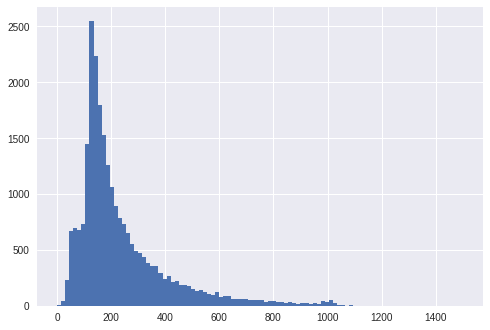

In [23]:
import matplotlib.pyplot as plt
length_data = [len(data) for data in train_data]
plt.hist(length_data, bins=100, range=(0, 1500))
print(np.percentile(length_data, 80))

Let's pad/truncate the reviews!

In [0]:
review_length = 150
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        maxlen=review_length)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, 
                                                       value=word_index["<PAD>"],
                                                       maxlen=review_length)

In [25]:
for i in range(10):
  print(len(train_data[i]))

150
150
150
150
150
150
150
150
150
150


Now let's create a NN with word embedings layer.

In [26]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
VOCAB_SIZE = 10000

# maximum number of words to use in a sequence
EMBED_SIZE = 20

#dim of an embedding
DIM = 8

# load IMDB dataset as lists of integers
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words= VOCAB_SIZE)

# convert our lists of integers into 2D tensors
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=EMBED_SIZE)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=EMBED_SIZE)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# create a Sequential model
model = Sequential()
# lets add our Embedding layer
model.add( Embedding(VOCAB_SIZE, DIM, input_length=EMBED_SIZE) )

# our output is a 3D tensor of shape (samples, VOCAB_SIZE, EMBED_SIZE)
# we will flatten it into a 2D tensor of shape (samples, VOCAB_SIZE * EMBED_SIZE)
model.add( Flatten() )

# Let's add a classifier.
model.add( Dense(1, activation='sigmoid') )
model.compile( optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'] )

model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 187us/step - loss: 0.6660 - acc: 0.6326 - val_loss: 0.6117 - val_acc: 0.7014
Epoch 2/10
20000/20000 [==============================] - 3s 168us/step - loss: 0.5356 - acc: 0.7547 - val_loss: 0.5227 - val_acc: 0.7316
Epoch 3/10
20000/20000 [==============================] - 3s 166us/step - loss: 0.4585 - acc: 0.7883 - val_loss: 0.4993 - val_acc: 0.7490
Epoch 4/10
20000/20000 [==============================] - 3s 170us/step - loss: 0.4198 - acc: 0.8118 - val_loss: 0.4946 - val_acc: 0.7586
Epoch 5/10
20000/20000 [==============================] - 3s 169us/step - loss: 0.3922 - acc: 0.8255 - val_loss: 0.4949 - val_acc: 0.7554
Epoch 6/10
20000/20000 [==============================] - 3s 174us/step - loss: 0.3689 - acc: 0.8375 - val_loss: 0.4985 - val_acc: 0.7544
Epoch 7/10
20000/20000 [==============================] - 3s 171us/step - loss: 0.3477 - acc: 0.8512 - val_loss: 0.5065 - v